In [1]:
from statistics import mean
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython import display
%matplotlib inline

# Creation of a class for the (simulated) real-time crypto chart

In [2]:
class RealTimeChart:
    def __init__(self, path):
        '''
        INPUT:
        path - Path to a crypto chart file
    
        Description:
        Creates a new chart based on a loaded crypto chart
        ''' 
        self.df = pd.read_csv(path, skiprows=[0])  # Read file with chart
        self.df = self.df.sort_values(by=['Date']) # Since it is in a reverse order, sort the chart ascendingly
        self.df = self.df.reset_index(drop=True)   # Reset old index
        
        # Set the index to 0
        self.index = 0

    def visualize(self):
        '''
        Description:
        Simply plots the whole chart
        '''
        plt.plot(self.df['Open'])
        return self.df.head(10)
        
    def get_current_price(self):
        '''
        OUTPUT:
        price
        
        Description:
        Return the current price.
        '''
        price = self.df.at[self.index, 'Open']
        return price

    def get_next_price(self):
        '''
        Description:
        Return the next price. Can be used to simulate a real-time price.
        '''
        self.index+=1
        if self.index > (self.df.shape[0] - 1):
            price = 0
        else:
            price = self.df.at[self.index, 'Open']
        return price
    
    def has_next_price(self):
        '''
        Description:
        Returns True if there is another price in the chart (False if not).
        '''
        if (self.index + 1) > (self.df.shape[0] - 1):
            return False
        else:
            return True
        
    def get_date(self):
        '''
        Description:
        Returns the current date (timestamp).
        '''
        date = self.df.at[self.index, 'Date']
        return date


In [3]:
class Wallet:
    def __init__(self, fiat):
        '''
        INPUT:
        fiat - Initial budget in FIAT currancy
    
        Description:
        Creates a new wallet with an initial budget
        ''' 
        self.fiat = fiat
        self.crypto = 0

    def buy_crypto(self, amount, price, charge_fee_percentage):
        '''
        INPUT:
        amount - Units of crypto currency to be bought
        price - Current price of crypto currancy in FIAT
        charge_fee_percentage - Charge fee (percentage value which is subtracted from amount value)

        Description:        
        Buy a defined amount of a crypto currancy.
        Returns True if order was successful (False if not)
        ''' 
        if (amount * price) <= self.fiat:
            self.fiat = self.fiat - (amount * price)
            self.crypto = self.crypto + (amount - (amount * charge_fee_percentage))
            print(amount, "crypto units bought for unit price of", price, "FIAT (Overall price:", amount * price, "FIAT)")
            print("Charge fee: ", (charge_fee_percentage * 100), "% ->", (amount - (amount * charge_fee_percentage)), "new crypto units in wallet")
            return True
        else:
            return False
        
    def buy_crypto_for(self, budget, price, charge_fee_percentage):
        '''
        INPUT:
        budget - Budget for which crypto currency shall be bought
        price - Current price of crypto currancy in FIAT
        charge_fee_percentage - Charge fee (percentage value which is subtracted from amount value)

        Description:        
        Buy crypto currancy  fir a defined budget.
        Returns True if order was successful (False if not)
        ''' 
        if budget <= self.fiat:
            self.fiat = self.fiat - budget
            self.crypto = self.crypto + (budget / price) - ((budget / price) * charge_fee_percentage)
            print("Crypto units bought for budget of", budget, "FIAT (Unit price: ", price, ")")
            print("Charge fee: ", (charge_fee_percentage * 100), "% ->", (budget / price) - ((budget / price) * charge_fee_percentage), "new crypto units in wallet")
            return True
        else:
            return False
        
    def sell_crypto(self, amount, price, charge_fee_percentage):
        '''
        INPUT:
        amount - Units of crypto currency to be sold
        price - Current price of crypto currancy in FIAT
        charge_fee_percentage - Charge fee (percentage value which is subtracted from overall sales price)

        Description:        
        Sells a defined amount of a crypto currancy.
        Returns True if order was successful (False if not)
        '''
        if amount <= self.crypto:
            self.crypto = self.crypto - amount
            self.fiat = self.fiat + ((amount * price) - (amount * price * charge_fee_percentage))
            print(amount, "crypto units sold for unit price of", price, "FIAT (Overall price:", amount * price, "FIAT)")
            print("Charge fee: ", (charge_fee_percentage * 100), "% ->", ((amount * price) - (amount * price * charge_fee_percentage)), "new FIAT units in wallet")
            return True
        else:
            return False
    
    def sell_crypto_for(self, budget, price, charge_fee_percentage):
        '''
        INPUT:
        budget - Budget (in FIAT currency) of crypto currency to be sold
        price - Current price of crypto currancy in FIAT
        charge_fee_percentage - Charge fee (percentage value which is subtracted from overall sales price)

        Description:        
        Sells a defined budget in FIAT currency of a crypto currancy.
        Returns True if order was successful (False if not)
        '''
        if (budget / price) <= self.crypto:
            return True
            self.crypto = self.crypto - (budget / price)
            self.fiat = self.fiat + budget - (budget * charge_fee_percentage)
            print("Crypto units sold for budget of", budget, "FIAT (Unit price: ", price, ")")
            print("Charge fee: ", (charge_fee_percentage * 100), "% ->", budget - (budget * charge_fee_percentage), "new FIAT units in wallet")
        else:
            return False
        
    
    def get_fiat(self):
        '''
        OUTPUT:
        self.fiat
        
        Description:
        Returns current number of euros.
        '''
        return self.fiat

    def get_crypto(self):
        '''
        OUTPUT:
        self.crypto
        
        Description:
        Returns current units of crypto currancy.
        '''
        return self.crypto

    def get_value(self, price):
        '''
        INPUT:
        price - Current price of crypto currancy in FIAT 
        
        OUTPUT:
        value - Current value of the wallet
        
        Description:
        Calculates the value of the wallet by adding value of crypto units with FIAT.
        '''
        return self.fiat + (self.crypto * price)
    
    def to_string(self, price):
        print("----------------")
        print("FIAT: ", self.fiat)
        print("CRYP: ", self.crypto, "->", self.crypto * price, "FIAT")
        print("SUM: ", self.get_value(price), "(FIAT)")
        print("----------------")


In [4]:
class Parameters:
    def __init__(self):
        self.trading_charge_fraction = 0.005
        self.stop_loss_fraction = 0.9
        self.mean_average_buy_fraction = 0.8
        self.mean_average_filter_length = 100
        
    def get_trading_charge_fraction(self):
        return self.trading_charge_fraction

    def get_stop_loss_fraction(self):
        return self.stop_loss_fraction

    def get_mean_average_buy_fraction(self):
        return self.mean_average_buy_fraction

    def get_mean_average_filter_length(self):
        return self.mean_average_filter_length


In [5]:
def get_price_vector(price_list, length, steps):
    price_vector = []
    i = 0
    for j in price_list[::-steps]:
        price_vector.append(j)
        i += 1
        if i == length:
            break
    return price_vector
    
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /
         ((mean(xs)*mean(xs)) - mean(xs*xs)))
    
    b = mean(ys) - m*mean(xs)
    
    return m, b


In [6]:
class Trader:
    def __init__(self, wallet, parameters, real_time_chart):
        self.wallet = wallet
        self.parameters = parameters
        self.real_time_chart = real_time_chart

    def run(self):
        '''
        OUTPUT:
        history - Complete value history of a run
    
        Description:
        tbd
        '''

        date = []
        price = []
        wallet_value = []
        stop_loss_limit = 0
        sum_of_last_prices = 0
        i = 0

        current_price = self.real_time_chart.get_current_price()
        date.append(self.real_time_chart.get_date())
        price.append(current_price)
        wallet_value.append(self.wallet.get_value(current_price))
        
        self.wallet.to_string(1000)
        self.wallet.buy_crypto_for(1000, self.real_time_chart.get_current_price(), self.parameters.get_trading_charge_fraction())
        stop_loss_limit = self.real_time_chart.get_current_price() * self.parameters.get_stop_loss_fraction()
        print("Stop loss limit is at", self.real_time_chart.get_current_price() * self.parameters.get_stop_loss_fraction())
        self.wallet.to_string(self.real_time_chart.get_current_price())
        
        while self.real_time_chart.has_next_price():
            self.real_time_chart.get_next_price()
            current_price = self.real_time_chart.get_current_price()
            date.append(self.real_time_chart.get_date())
            price.append(current_price)
            wallet_value.append(self.wallet.get_value(current_price))
            
            # Raise stop loss limit if there is growth
            if (stop_loss_limit / 0.9) < current_price and self.wallet.get_crypto() > 0:
                stop_loss_limit = current_price * self.parameters.get_stop_loss_fraction()
                print("Current price is", current_price, " -> Increase stop loss limit to", stop_loss_limit)
            
            # Check for sell signal
            if(stop_loss_limit > current_price):
                if self.wallet.get_crypto() > 0:
                    print("--- SELL SIGNAL: Stop loss limit undershoot at ", self.real_time_chart.get_date(), "---")
                    self.wallet.sell_crypto(self.wallet.get_crypto(), current_price, self.parameters.get_trading_charge_fraction())
                    
            # Calculate mean average
            sum_of_last_prices = sum_of_last_prices + current_price
            if i >= self.parameters.get_mean_average_filter_length():
                sum_of_last_prices = sum_of_last_prices - price[i - self.parameters.get_mean_average_filter_length()]
                mean_average = sum_of_last_prices / self.parameters.get_mean_average_filter_length()
                    
                # Check for buy signal
                if self.wallet.get_fiat() > 0:
                    if current_price < mean_average * self.parameters.get_mean_average_buy_fraction():
                        print("--- BUY SIGNAL: Price below mean average fraction limit of", mean_average, "at", self.real_time_chart.get_date(), "---")
                        self.wallet.buy_crypto_for(self.wallet.get_fiat(), current_price, self.parameters.get_trading_charge_fraction())
                        stop_loss_limit = current_price * self.parameters.get_stop_loss_fraction()
            
            # Increment counter
            i += 1
            
        history = pd.DataFrame(list(zip(date, price, wallet_value)), columns =['Date', 'Price', 'Wallet_Value'])            
            
        self.wallet.sell_crypto(self.wallet.get_crypto(), self.real_time_chart.get_current_price(), self.parameters.get_trading_charge_fraction())
        self.wallet.to_string(self.real_time_chart.get_current_price())
        
        return history


In [7]:
def calc_growth(df):
    '''
    INPUT
    df - Data frame to be analyzed
    
    Description:
    Show growth over the time
    '''
    print("Open:", df.at[0, 'Open'])
    print("Close:", df.at[df.shape[0] - 1, 'Open'])
    growth = ((df.at[df.shape[0] - 1, 'Open'] / df.at[0, 'Open']) - 1) * 100
    print("Growth:", round(growth, 3), "%")
        

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1577836800000,2020-01-01 00:00:00,ETHUSD,128.84,128.84,128.74,128.74,0.010000
1,1577836860000,2020-01-01 00:01:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
2,1577836920000,2020-01-01 00:02:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
3,1577836980000,2020-01-01 00:03:00,ETHUSD,128.74,128.74,128.74,128.74,0.000000
4,1577837040000,2020-01-01 00:04:00,ETHUSD,128.74,128.74,128.49,128.50,4.039458
5,1577837100000,2020-01-01 00:05:00,ETHUSD,128.50,128.50,128.50,128.50,0.000000
6,1577837160000,2020-01-01 00:06:00,ETHUSD,128.50,128.50,128.50,128.50,0.000000
7,1577837220000,2020-01-01 00:07:00,ETHUSD,128.50,128.50,128.41,128.41,1.627411
8,1577837280000,2020-01-01 00:08:00,ETHUSD,128.41,128.41,128.41,128.41,0.000000
9,1577837340000,2020-01-01 00:09:00,ETHUSD,128.41,128.41,128.41,128.41,0.000000


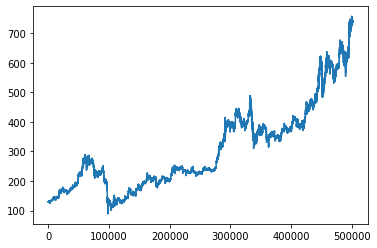

In [8]:
# Create real-time chart
my_chart = RealTimeChart('./gemini_ETHUSD_2020_1min.csv')
my_chart.visualize()

In [9]:
# Create wallet with 1000 units of fiat currency
my_wallet = Wallet(1000)

# Create parameters for trading
my_parameters = Parameters()

# Create trader and inject the wallet and the chart
my_trader = Trader(my_wallet, my_parameters, my_chart)
history = my_trader.run()

----------------
FIAT:  1000
CRYP:  0 -> 0 FIAT
SUM:  1000 (FIAT)
----------------
Crypto units bought for budget of 1000 FIAT (Unit price:  128.84 )
Charge fee:  0.5 % -> 7.72275690779261 new crypto units in wallet
Stop loss limit is at 115.956
----------------
FIAT:  0
CRYP:  7.72275690779261 -> 995.0 FIAT
SUM:  995.0 (FIAT)
----------------
Current price is 128.99  -> Increase stop loss limit to 116.09100000000001
Current price is 129.0  -> Increase stop loss limit to 116.10000000000001
Current price is 129.65  -> Increase stop loss limit to 116.685
Current price is 129.84  -> Increase stop loss limit to 116.85600000000001
Current price is 130.01  -> Increase stop loss limit to 117.009
Current price is 130.1  -> Increase stop loss limit to 117.09
Current price is 130.23  -> Increase stop loss limit to 117.207
Current price is 130.56  -> Increase stop loss limit to 117.504
Current price is 130.57  -> Increase stop loss limit to 117.51299999999999
Current price is 130.75  -> Increase 

Current price is 172.53  -> Increase stop loss limit to 155.27700000000002
Current price is 172.6  -> Increase stop loss limit to 155.34
Current price is 174.32  -> Increase stop loss limit to 156.888
Current price is 174.42  -> Increase stop loss limit to 156.97799999999998
Current price is 175.15  -> Increase stop loss limit to 157.63500000000002
Current price is 175.49  -> Increase stop loss limit to 157.941
Current price is 175.64  -> Increase stop loss limit to 158.076
Current price is 176.38  -> Increase stop loss limit to 158.742
Current price is 177.46  -> Increase stop loss limit to 159.714
Current price is 177.5  -> Increase stop loss limit to 159.75
Current price is 178.06  -> Increase stop loss limit to 160.25400000000002
Current price is 178.23  -> Increase stop loss limit to 160.40699999999998
Current price is 178.75  -> Increase stop loss limit to 160.875
Current price is 179.65  -> Increase stop loss limit to 161.685
--- SELL SIGNAL: Stop loss limit undershoot at  2020-

In [10]:
history.head(20)

,Date,Price,Wallet_Value
0,2020-01-01 00:00:00,128.84,1000.000000
1,2020-01-01 00:01:00,128.74,994.227724
2,2020-01-01 00:02:00,128.74,994.227724
3,2020-01-01 00:03:00,128.74,994.227724
4,2020-01-01 00:04:00,128.74,994.227724
5,2020-01-01 00:05:00,128.50,992.374263
6,2020-01-01 00:06:00,128.50,992.374263
7,2020-01-01 00:07:00,128.50,992.374263
8,2020-01-01 00:08:00,128.41,991.679215
9,2020-01-01 00:09:00,128.41,991.679215
